This notebook walks through a dataset collected in the UCLA 2026 course by _Karolina Socha_ and _Adidya Singh_. 

This notebook is adapted from the _AL_chronic_dataset_ tutorial on visual responses.

In [134]:
from pathlib import Path
import numpy as np 
import pylab as plt
# for interactivity
%matplotlib qt 

# path to the data sorted by ece_phys and with sync signals processed by CatGT
outfolder = Path('C:/ece_out/catgt_ephysData_motCtx_AS_g0')

from helpers import load_phy_folder  # load the function from the previous tutorial
res = load_phy_folder(outfolder) # this is converted to a function in the helpers
sampling_rate = 30000 # this can be read from the params.py file or from the .meta

stimtimes = np.loadtxt(outfolder.rglob('*tcat.obx0.obx.xa_4_0.adj.txt').__next__())
# this is a list of events
stimtimes = ss.reshape(3,-1,8)
stimtimes = stimtimes.transpose(1,2,0) # reshape to have it in the form: ntrial x nstim x feature


It is often useful to get an overview of task or stimulus events in the context of the drift raster, these can be easily overlayed.

Based on the previous plot, there is a function in the helpers to a ``plot_drift_raster``

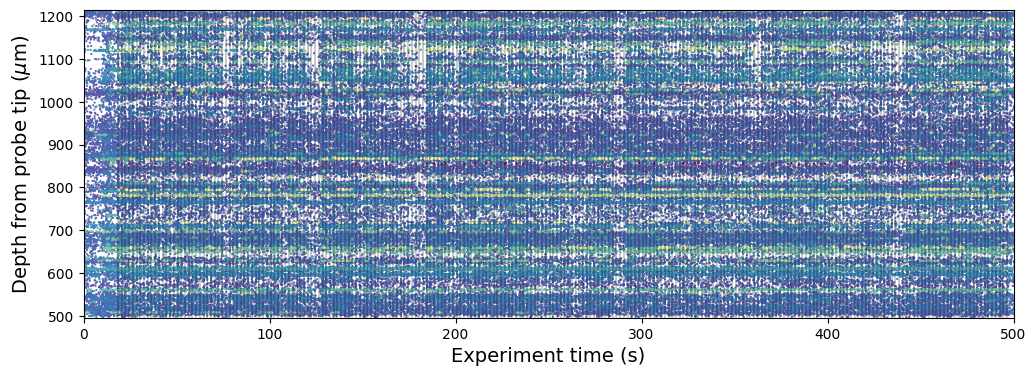

In [132]:
from helpers import plot_drift_raster
# plot the stim times alongside
plot_drift_raster(spiketimes = res['spike_times']/sampling_rate,
                  spikepositions = res['spike_positions'],
                  spikeamplitudes = res['spike_amplitudes'])
for p in range(stimtimes.shape[-1]):                
    plt.vlines(stimtimes[:,:,p],*plt.ylim(),lw = 0.3,color = 'k')

plt.ylabel('Depth from probe tip ($\\mu$m)',fontsize = 14)
plt.xlabel('Experiment time (s)',fontsize = 14);
plt.xlim([0,500]);

It is hard to see the effect of the stimulus, lets plot a ``PSTH`` **peri-stimulus time histogram** of population activity. This, together with **trial rasters** should tell us if the synchronization between the streams is ok.

_Here we plot a PSTH for each spatial frequency (the last dimension of stimtimes)._

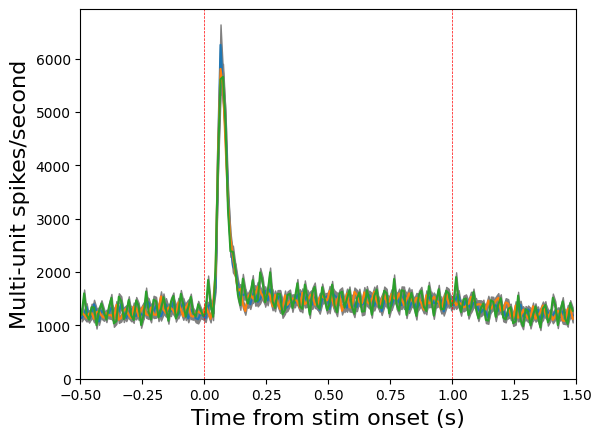

In [130]:
# triggered psth
interval = [-0.5,1.5]
ts = res['spike_times']/sampling_rate
binsize = 0.01 # binsize
bins = np.arange(*interval,binsize)
plt.figure()
for isf in range(stimtimes.shape[-1]): # the last dimension is the spatial frequency 
    ev = stimtimes[:,:,isf].flatten()
    triggered_population = [ts[(ts>interval[0]+e) & (ts<interval[1]+e)] - e for e in ev]
    # create a histogram of the trials separately so we can get a mean and std easily
    pop_psths = np.stack([np.histogram(t,bins = bins)[0] for t in triggered_population]).astype('float32')
    pop_psths /= binsize
    t = bins[1:] - np.diff(bins[:2])/2

    psth = np.mean(pop_psths,axis = 0)
    psth_sem =  np.std(pop_psths,axis = 0)/np.sqrt(len(pop_psths))
    
    plt.fill_between(t,psth+psth_sem,psth-psth_sem,color = 'gray')
    plt.plot(t,psth)
plt.ylim([0,np.max(plt.ylim())])
plt.xlim(*interval)
plt.vlines([0,1],*plt.ylim(),color = 'r',linestyle = '--',lw =0.5)
plt.ylabel('Multi-unit spikes/second',fontsize = 16)
plt.xlabel('Time from stim onset (s)',fontsize = 16);

Lets now look at the response of individual cells to the stimuli.

In [114]:
# first lets create a list of spikes for each clusters
unit_spikes = []
for iclu in res['metrics'].cluster_id.values:
    unit_spikes.append(np.take(res['spike_times'],np.where(res['spike_clusters']==iclu)[0])/sampling_rate)
print(f'Gathered spike times from {len(unit_spikes)} units.')

# extract a raster for each unit for each stimuli
ntrials,nstims ,_ = stimtimes.shape
triggered_activity = []
interval = [-0.5,1.5]
for ts in unit_spikes: # iterate over units
    triggered_activity.append([])
    for isf in range(stimtimes.shape[-1]):
        for istim in range(nstims): # iterate over stimuli
            ev = stimtimes[:,istim,isf]
            triggered_activity[-1].extend([ts[(ts>interval[0]+e) & (ts<interval[1]+e)] - e for e in ev])

print(f'Gathered the activity from {nstims} stims and {ntrials} trials.')


Gathered spike times from 462 units.
Gathered the activity from 8 stims and 10 trials.


Lets now use ``ipywidgets`` to cycle through all cells.

<Figure size 640x480 with 0 Axes>

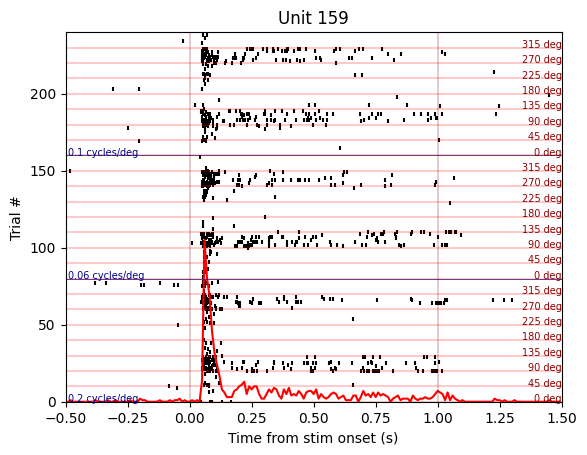

In [120]:
# plot an interactive raster to go over the activity of the cells
fig = plt.figure()
%matplotlib inline

# plot an interactive raster to go over the activity of the cells
fig = plt.figure()
from ipywidgets import IntSlider,interact
@interact(icell = IntSlider(value = 159, min=0,max=len(unit_spikes)-1))
def raster_slider(icell):
    triggered = triggered_activity[icell]
    trial_index = np.hstack([i*np.ones_like(s) for i,s in enumerate(triggered)])
    trial_spikes = np.hstack(triggered)
    fig.clf()
    scatt = plt.scatter(trial_spikes,trial_index,5,'k',marker = '|');
    plt.plot(bins[1:],np.histogram(np.hstack(trial_spikes),bins = bins)[0], color='r')
    plt.title(f"Unit {int(res['metrics'].iloc[icell]['cluster_id'])}")
    plt.xlim(interval)
    plt.ylim([0,len(triggered_activity[0])]);
    plt.vlines([0,1],*plt.ylim(),color = 'darkred',linestyle = '-',lw = 0.3);
    plt.hlines(80*np.arange(3),-.5,1.5,color = 'darkblue',lw  = 0.5)
    for sf,tloc in zip([0.2,0.06,0.1],80*np.arange(3)):
        plt.text(-0.49,tloc,f'{sf} cycles/deg',color = 'darkblue',fontsize = 7)
        for ori,oloc in zip(np.linspace(0,315,nstims),range(nstims)):
            plt.text(1.5,tloc+10*oloc,f'{int(ori)} deg',
                     color = 'darkred',
                     ha = 'right',
                     fontsize = 7)
    plt.hlines(10*np.arange(8*3),-.5,1.5,lw = 0.3,color = 'r')
    plt.xlabel('Time from stim onset (s)')
    plt.ylabel('Trial #')


**Exercise**

Plot a PSTH aligned with the rasters and cicle through all cells using the slider.


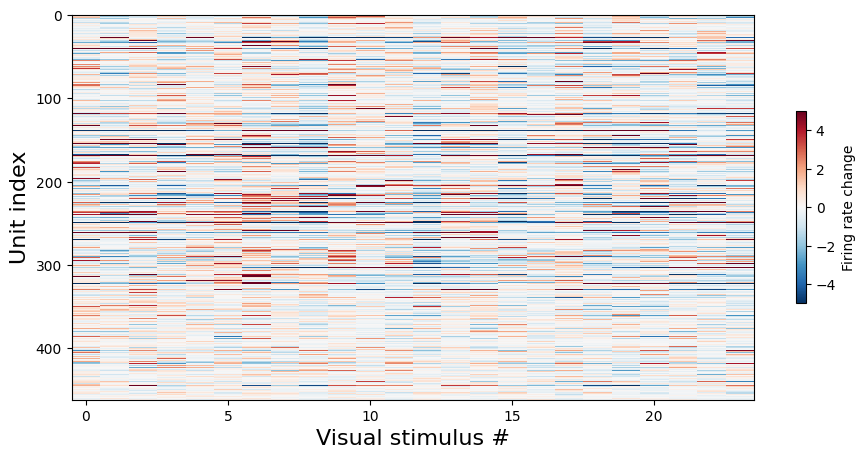

In [128]:
# plot "fingerprints" - these are the average response to each stimuli subtracted by the average response during the stim period
stims = stimtimes.reshape(-1,np.multiply(*stimtimes.shape[1:]))
fingerprints = []
interval = [0,1]
for ts in unit_spikes: # iterate over units
    fingerprints.append([])
    for istim in range(stims.shape[1]): # iterate over stimuli
        ev = stims[:,istim]
        fingerprints[-1].append(np.mean([len(ts[(ts>interval[0]+e) & (ts<interval[1]+e)]) for e in ev]))
fingerprints = np.stack(fingerprints)
fingerprints = (fingerprints.T - fingerprints.mean(axis = 1)).T
plt.figure(figsize = [11,5])

plt.imshow(fingerprints,cmap = 'RdBu_r',clim = [-5,5],interpolation='none',aspect = 'auto')
plt.colorbar(label='Firing rate change',shrink = 0.5)
plt.ylabel('Unit index',fontsize = 16)
plt.xlabel('Visual stimulus #',fontsize = 16);

 We can use **similarity** clustering to sort the cells by their responses.

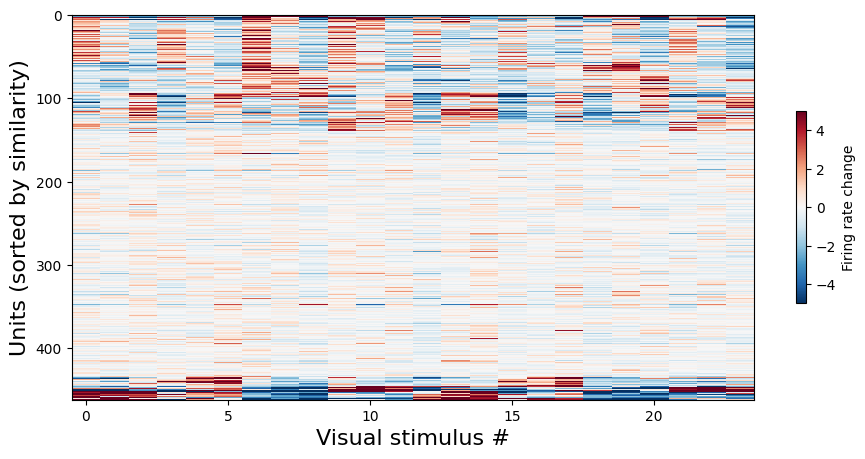

In [129]:
# use hierarchical clustering to group similar "fingerprints"
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering, dendrogram,fcluster


dist_matrix = pdist(fingerprints, metric='euclidean')
linkage_matrix = linkage(dist_matrix, method='ward')
idx = np.argsort(fcluster(linkage_matrix,fingerprints.shape[1],criterion='maxclust'))

plt.figure(figsize = [11,5])
plt.imshow(fingerprints[idx],cmap = 'RdBu_r',clim = [-5,5],interpolation='none',aspect = 'auto')
plt.colorbar(label='Firing rate change',shrink = 0.5)
plt.ylabel('Units (sorted by similarity)',fontsize = 16)
plt.xlabel('Visual stimulus #',fontsize = 16);